# Importing The Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, img_as_float
from skimage.util import random_noise
import cv2
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
np.random.seed(42)
torch.manual_seed(42)

# Loading + Preprocessing The Image

(-0.5, 511.5, 511.5, -0.5)

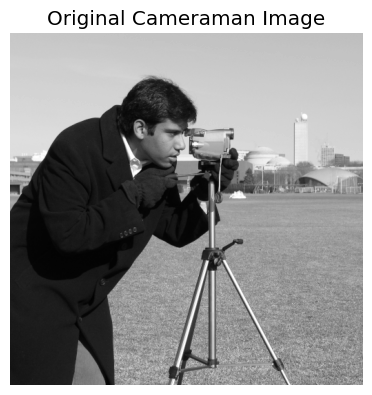

In [4]:
image = data.camera()

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Cameraman Image')
plt.axis('off')

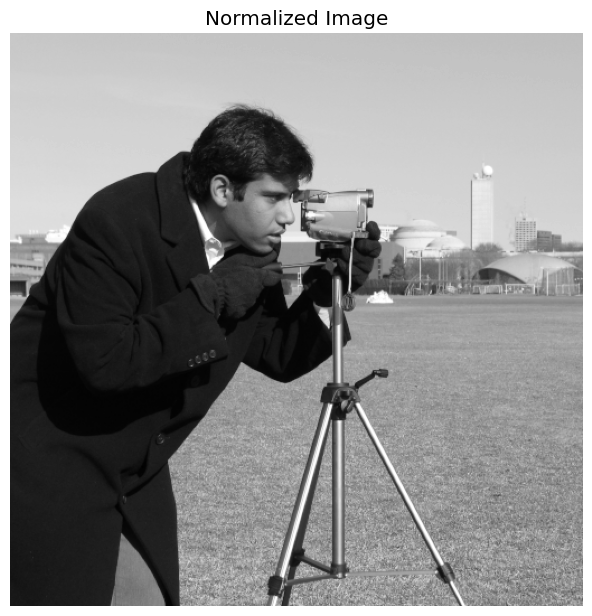

In [5]:
image_float = img_as_float(image)

plt.subplot(1, 2, 2)
plt.imshow(image_float, cmap='gray')
plt.title('Normalized Image')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
height, width = image_float.shape
print(f"Image dimensions: {height} x {width}")
print(f"Min and max values: {image_float.min():.4f}, {image_float.max():.4f}")

Image dimensions: 512 x 512
Min and max values: 0.0000, 1.0000


# Adding Noise to Image

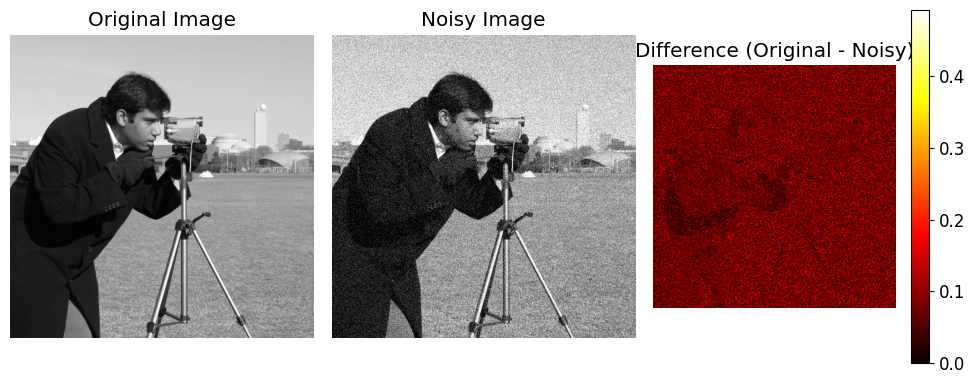

In [7]:
noisy_image = random_noise(image_float, mode='gaussian', var=0.01, seed=42)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_float, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(image_float - noisy_image), cmap='hot')
plt.title('Difference (Original - Noisy)')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

In [8]:
X = image_float 
X_noisy = noisy_image  
noise_error = np.linalg.norm(X - X_noisy, 'fro')
print(f"Frobenius norm error of noisy image: {noise_error:.4f}")

Frobenius norm error of noisy image: 48.7774


# Reconstruction with SVD

In [9]:
U, S, Vt = np.linalg.svd(X_noisy, full_matrices=False)

full_rank = len(S)
print(f"Full rank of image: {full_rank}")

Full rank of image: 512


In [10]:
errors_svd = []
reconstructed_images_svd = []

max_r_for_plot = min(100, full_rank)
ranks = list(range(1, max_r_for_plot + 1))

for r in ranks:
    X_reconstructed = U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :]
    reconstructed_images_svd.append(X_reconstructed)
    
    error = np.linalg.norm(X - X_reconstructed, 'fro')
    errors_svd.append(error)

errors_svd = np.array(errors_svd)

diff_errors = np.diff(errors_svd)
diff2_errors = np.diff(diff_errors)

threshold = 0.01 * np.max(np.abs(diff2_errors))
inflection_points = np.where(np.abs(diff2_errors) < threshold)[0]

if len(inflection_points) > 0:
    r_opt_svd = inflection_points[0] + 2  
else:
    error_reduction = errors_svd[0] - errors_svd
    target_reduction = 0.95 * error_reduction[-1]  
    r_opt_svd = np.argmax(error_reduction >= target_reduction) + 1

print(f"Optimal rank for SVD (r*_SVD): {r_opt_svd}")

Optimal rank for SVD (r*_SVD): 8


# Reconstruction with PCA

In [11]:
pca_img = PCA()
pca_img.fit(X_noisy)  

errors_pca = []
reconstructed_images_pca = []

for r in ranks:
    X_transformed = pca_img.transform(X_noisy)
    
    X_transformed_r = X_transformed.copy()
    X_transformed_r[:, r:] = 0
    
    X_reconstructed_pca = pca_img.inverse_transform(X_transformed_r)
    
    reconstructed_images_pca.append(X_reconstructed_pca)
    
    error = np.linalg.norm(X - X_reconstructed_pca, 'fro')
    errors_pca.append(error)

errors_pca = np.array(errors_pca)

error_reduction_pca = errors_pca[0] - errors_pca
target_reduction_pca = 0.95 * error_reduction_pca[-1]
r_opt_pca = np.argmax(error_reduction_pca >= target_reduction_pca) + 1

print(f"Optimal rank for PCA (r*_PCA): {r_opt_pca}")

Optimal rank for PCA (r*_PCA): 12


# Plotting Reconstruction Errors

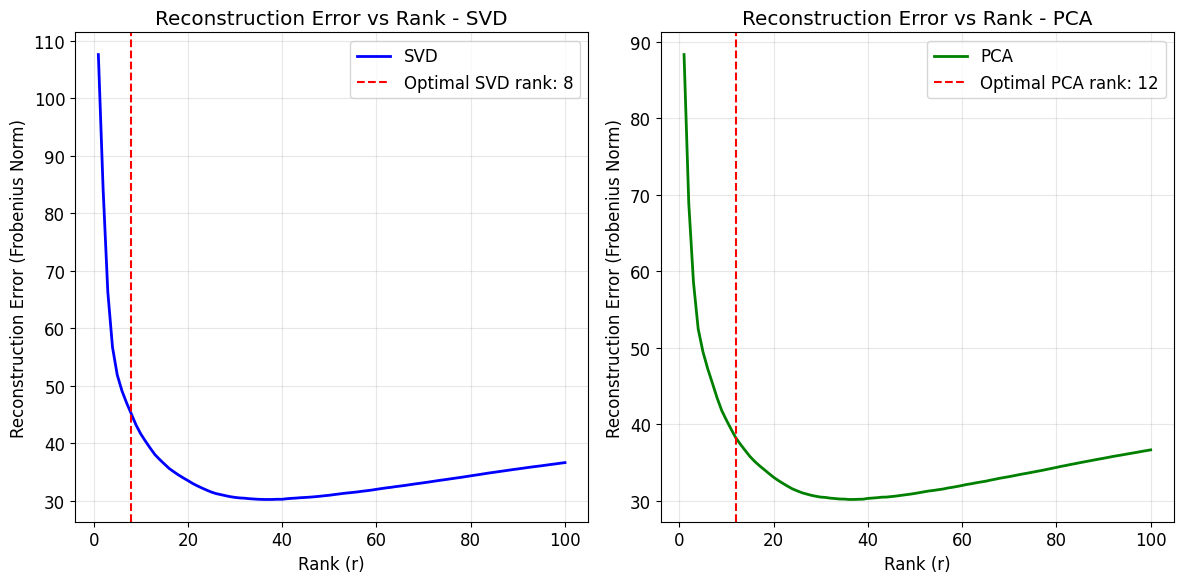

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(ranks, errors_svd, 'b-', linewidth=2, label='SVD')
plt.axvline(x=r_opt_svd, color='r', linestyle='--', label=f'Optimal SVD rank: {r_opt_svd}')
plt.xlabel('Rank (r)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.title('Reconstruction Error vs Rank - SVD')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ranks, errors_pca, 'g-', linewidth=2, label='PCA')
plt.axvline(x=r_opt_pca, color='r', linestyle='--', label=f'Optimal PCA rank: {r_opt_pca}')
plt.xlabel('Rank (r)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.title('Reconstruction Error vs Rank - PCA')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

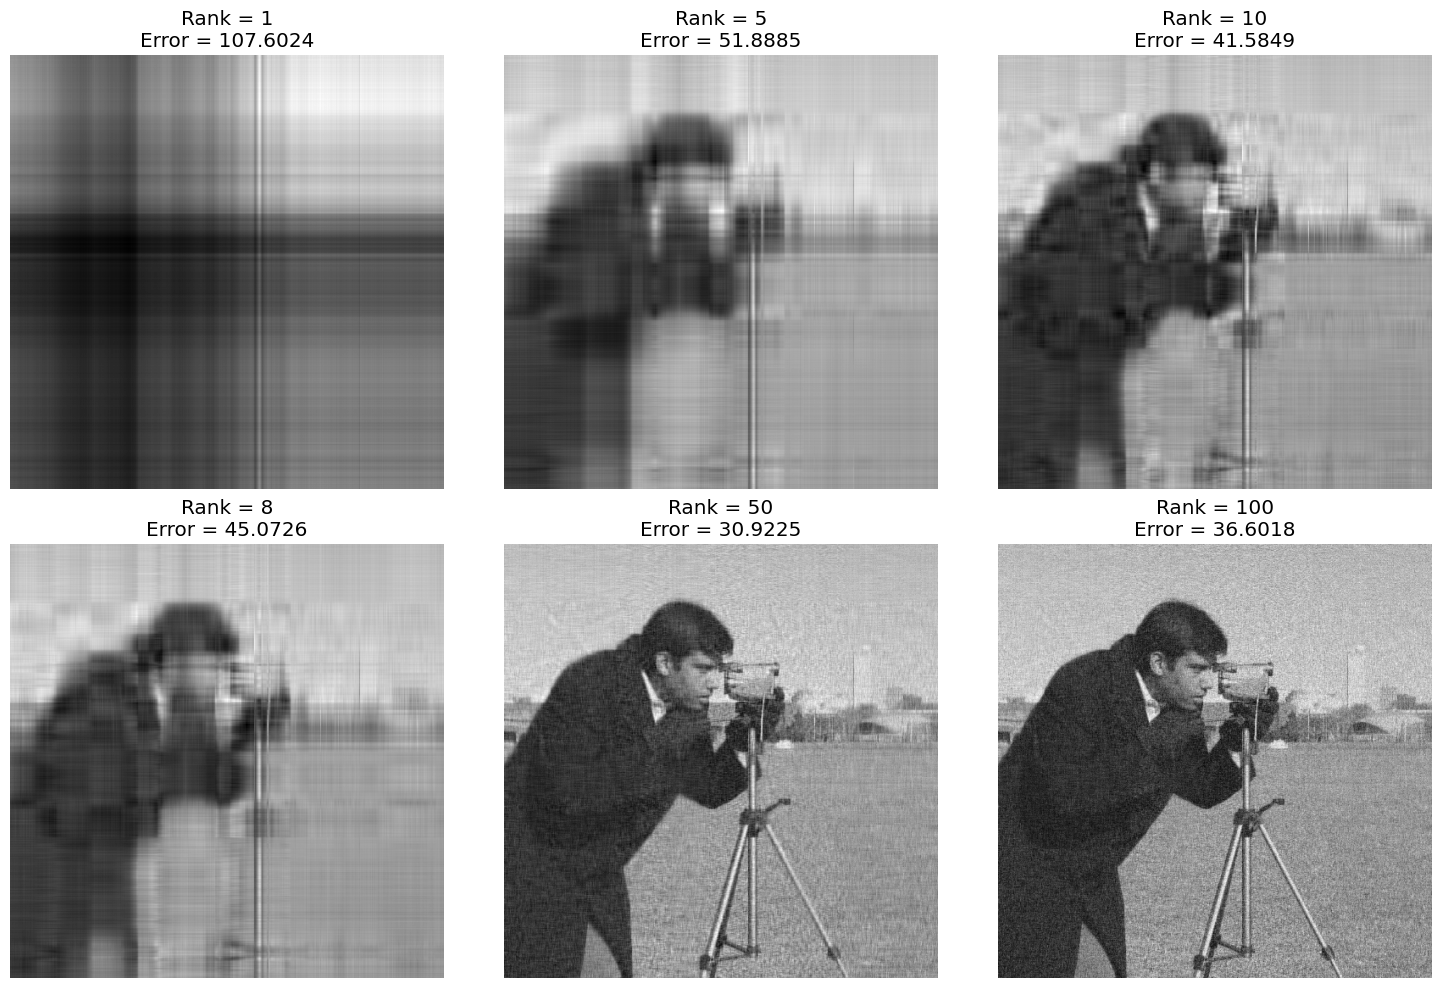

In [13]:
r_samples = [1, 5, 10, r_opt_svd, 50, 100]
n_samples = len(r_samples)

plt.figure(figsize=(15, 10))
for i, r in enumerate(r_samples):
    if r <= max_r_for_plot:
        plt.subplot(2, 3, i+1)
        X_reconstructed = reconstructed_images_svd[r-1]
        plt.imshow(X_reconstructed, cmap='gray')
        error = np.linalg.norm(X - X_reconstructed, 'fro')
        plt.title(f'Rank = {r}\nError = {error:.4f}')
        plt.axis('off')

plt.tight_layout()
plt.show()